Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display

In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


Importing Models

In [3]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

Reading in & Processing Data

In [4]:
dataset = pd.read_csv('diabetes.csv')

# assuming 0 values in dataset are missing data, thus removing them (except pregnancies and outcome)
filtered_dataset = dataset[(dataset['BMI'] != 0) & 
                           (dataset['BloodPressure'] != 0) & 
                           (dataset['Glucose'] != 0) & 
                           (dataset['SkinThickness'] != 0) & 
                           (dataset['Insulin'] != 0)]

columns_to_exclude = ['Outcome', 'Pregnancies']
rows_with_zeros = (filtered_dataset.drop(columns=columns_to_exclude) == 0).any(axis=1)

print(filtered_dataset[rows_with_zeros])
filtered_dataset.head()

Empty DataFrame
Columns: [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome]
Index: []


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
6,3,78,50,32,88,31.0,0.248,26,1
8,2,197,70,45,543,30.5,0.158,53,1
13,1,189,60,23,846,30.1,0.398,59,1


Separating Data

In [5]:
x = filtered_dataset.iloc[:, :-1].values
y = filtered_dataset.iloc[:, -1].values

Generating Training & Test Sets

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)

Applying Feature Scaling

In [7]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

Choosing Best Classification Model

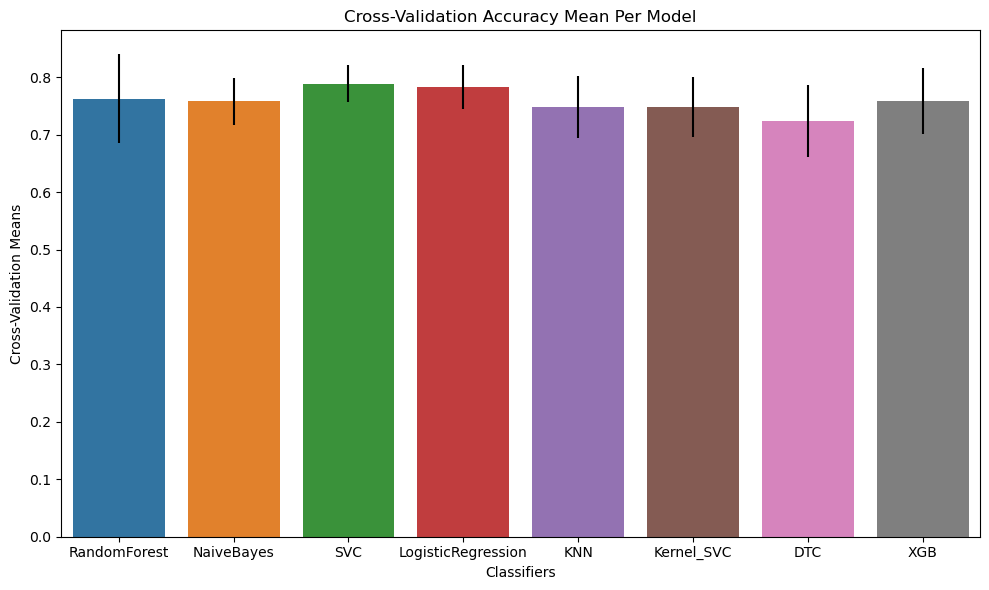

In [8]:
classifiers = {
    'RandomForest': RandomForestClassifier(n_estimators=20, criterion='entropy', random_state=0),
    'NaiveBayes': GaussianNB(),
    'SVC': SVC(kernel = 'linear', random_state = 0),
    'LogisticRegression': LogisticRegression(random_state = 0),
    'KNN': KNeighborsClassifier(n_neighbors = 5, metric = "minkowski", p = 2),
    'Kernel_SVC': SVC(kernel = "rbf", random_state = 0),
    'DTC': DecisionTreeClassifier(criterion = "entropy", random_state = 0),
    'XGB': XGBClassifier()
}

results = {'Classifier': [], 'ConfusionMatrix': [], 'Accuracy': [], 'CrossValAccuracyMean': [], 'CrossValAccuracyStd': []}

for name, classifier in classifiers.items():
    classifier.fit(x_train, y_train)
    y_pred = classifier.predict(x_test)
    
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies = cross_val_score(estimator=classifier, X=x_train, y=y_train, cv=10)
    mean_accuracy = accuracies.mean()
    std_accuracy = accuracies.std()

    results['Classifier'].append(name)
    results['ConfusionMatrix'].append(cm)
    results['Accuracy'].append(accuracy)
    results['CrossValAccuracyMean'].append(mean_accuracy)
    results['CrossValAccuracyStd'].append(std_accuracy)

results_df = pd.DataFrame(results)

plt.figure(figsize = (10, 6))
sns.barplot(x = 'Classifier', y = 'CrossValAccuracyMean', data = results_df, yerr = results_df['CrossValAccuracyStd'])
plt.title('Cross-Validation Accuracy Mean Per Model')
plt.xlabel('Classifiers')
plt.ylabel('Cross-Validation Means')
plt.tight_layout()
plt.show()

In [9]:
print(results_df)

           Classifier       ConfusionMatrix  Accuracy  CrossValAccuracyMean  \
0        RandomForest   [[58, 7], [13, 20]]  0.795918              0.762644   
1          NaiveBayes  [[55, 10], [10, 23]]  0.795918              0.758506   
2                 SVC   [[59, 6], [16, 17]]  0.775510              0.789310   
3  LogisticRegression   [[60, 5], [15, 18]]  0.795918              0.782644   
4                 KNN   [[59, 6], [13, 20]]  0.806122              0.748506   
5          Kernel_SVC   [[59, 6], [16, 17]]  0.775510              0.748391   
6                 DTC  [[52, 13], [16, 17]]  0.704082              0.724483   
7                 XGB   [[58, 7], [16, 17]]  0.765306              0.759080   

   CrossValAccuracyStd  
0             0.077388  
1             0.041057  
2             0.031887  
3             0.038482  
4             0.053398  
5             0.052148  
6             0.062763  
7             0.057005  


Confusion Matrix Heat Map Based on SVC

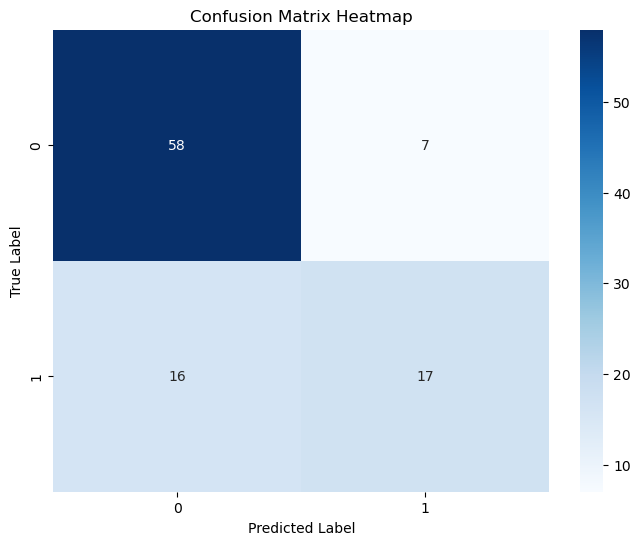

In [10]:
svc = SVC(kernel = 'linear', random_state=0)
svc.fit(x_train, y_train)

cm = confusion_matrix(y_test, y_pred)
heatmap_data = pd.DataFrame(cm, index = svc.classes_, columns = svc.classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot = True, fmt = 'd', cmap = 'Blues')
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

SVC - Key Features

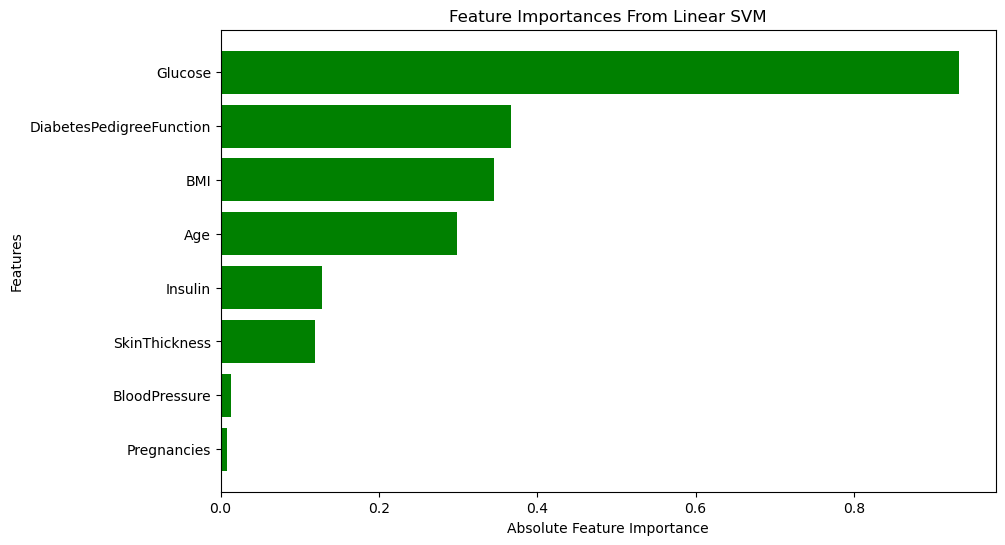

In [11]:
features_list = dataset.columns[:-1]
feature_importances = svc.coef_[0]  

sorted_idx = np.argsort(np.abs(feature_importances))

plt.figure(figsize = (10, 6))
plt.barh(range(len(sorted_idx)), np.abs(feature_importances[sorted_idx]), color="green")
plt.yticks(range(len(sorted_idx)), features_list[sorted_idx])
plt.title('Feature Importances From Linear SVM')
plt.xlabel('Absolute Feature Importance')
plt.ylabel('Features')
plt.show()

Widget for Predicting User Inputs

In [12]:
pregnancies_input = widgets.IntText(description = 'Pregnancies:')
glucose_input = widgets.IntText(description = 'Glucose Concentration:')
blood_pressure_input = widgets.IntText(description = 'Blood Pressure:')
skin_thickness_input = widgets.IntText(description = 'Skin Thickness:')
insulin_input = widgets.IntText(description = 'Insulin Level:')
bmi_input = widgets.FloatText(description = 'BMI:')
diabetes_pedigree_input = widgets.FloatText(description = 'Diabetes Pedigree:')
age_input = widgets.IntText(description ='Age:')

def predict_diabetes(pregnancies, glucose, blood_pressure, skin_thickness, insulin, bmi, diabetes_pedigree, age):
    input_data = np.array([[pregnancies, glucose, blood_pressure, skin_thickness, insulin, bmi, diabetes_pedigree, age]])
    prediction = svc.predict(sc.transform(input_data))
    return 'Diabetes Prediction: {}'.format('Yes' if prediction[0] == 1 else 'No')
    
def on_button_click(button):
    result_output.clear_output()
    with result_output:
        result = predict_diabetes(
            pregnancies_input.value,
            glucose_input.value,
            blood_pressure_input.value,
            skin_thickness_input.value,
            insulin_input.value,
            bmi_input.value,
            diabetes_pedigree_input.value,
            age_input.value
        )
        print(result)

run_button = widgets.Button(description = 'Run Prediction')
run_button.on_click(on_button_click)

result_output = widgets.Output()

vb = widgets.VBox([
    pregnancies_input, glucose_input, blood_pressure_input, skin_thickness_input, insulin_input, bmi_input, 
    diabetes_pedigree_input, age_input, run_button, result_output
])

display(vb)